This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [1]:
import os
os.getcwd()
os.chdir("..")
os.chdir("..")
os.getcwd()

'/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit'

In [2]:
import convokit

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [4]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus-small"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus-small


In [6]:
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10, include_root=False)

In [26]:
motif_path_stats = hc.retrieve_motif_pathway_stats(corpus)

In [31]:
feat_df = pd.DataFrame(data=0, index=motif_paths.keys(), columns=convokit.TriadMotif.paths_list())

In [36]:
for thread_id, motif_path_stats_dict in motif_path_stats.items():
    for motif_path, val in motif_path_stats_dict.items():
        feat_df.loc[thread_id][motif_path] = val

In [38]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [39]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [40]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [42]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=convokit.TriadMotif.paths_list())

As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [45]:
threads = corpus.utterance_threads(prefix_len=10, include_root=False)

In [47]:
def get_subreddit(threads, thread_id):
    return threads[thread_id][thread_id].meta["subreddit"]

In [48]:
subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = subreddits

In [49]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [50]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

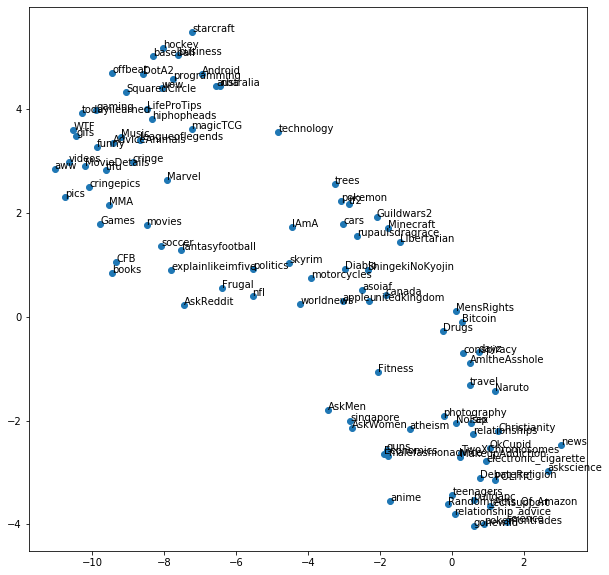

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

In [55]:
subreddit_means

,0,1,2,3,4,5,6
subreddit,,,,,,,
AdviceAnimals,0.185563,-0.138246,0.012819,-0.062370,-0.026362,-0.012398,0.015571
AmItheAsshole,-0.395484,-0.096399,-0.074687,-0.099110,-0.079698,-0.011501,0.051233
Android,0.108267,-0.229656,0.194735,-0.166134,-0.034542,-0.026632,0.014458
AskMen,-0.032722,-0.115251,-0.138892,-0.085710,-0.052254,-0.032162,0.033042
AskReddit,0.049488,-0.113984,-0.135368,-0.038469,-0.037043,0.022006,0.004097
AskWomen,-0.085804,-0.140060,-0.183671,-0.114414,-0.069839,-0.000779,0.028282
Bitcoin,-0.306162,-0.079760,-0.008573,-0.131219,-0.090295,-0.028067,0.030784
CFB,0.168616,-0.109958,-0.137873,-0.058338,-0.066909,-0.009015,0.027951
Christianity,-0.492554,-0.026731,-0.202047,-0.018427,-0.099819,0.013931,0.032405


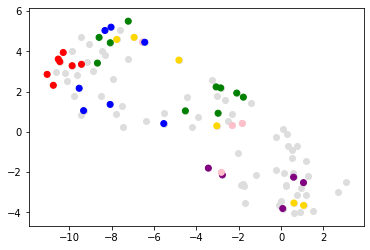

In [70]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]
tech = ["Android", "apple", "technology", "techsupport", "programming", "buildapc"]
reaction_bait = ["WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]
countries = ["singapore", "canada", "unitedkingdom", "australia"]
plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in tech else
    "purple" if l in relationships else
    "red" if l in reaction_bait else
    "blue" if l in sports else
    "pink" if l in countries else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [62]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [63]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [64]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                    p2      dist
3810            Diablo  0.024230
3833  ShingekiNoKyojin  0.043540
3896     unitedkingdom  0.045366
3840            asoiaf  0.055645
3867       motorcycles  0.059321
3814           Fitness  0.077223
3848            canada  0.086641
3898         worldnews  0.088674
3849              cars  0.099017
3881   rupaulsdragrace  0.116004

politics
                   p2      dist
7771              nfl  0.051632
7785           skyrim  0.063796
7756  fantasyfootball  0.070496
7715           Frugal  0.070555
7798        worldnews  0.074798
7767      motorcycles  0.078841
7718             IAmA  0.080206
7786           soccer  0.101382
7723           Marvel  0.121101
7738            apple  0.169405

leagueoflegends
                 p2      dist
6427          Music  0.013351
6451         cringe  0.023854
6462    hiphopheads  0.026340
6400  AdviceAnimals  0.028460
6420    LifeProTips  0.029462
6434  SquaredCircle  0.040156
6499            wow  0.046521
6423        

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [41]:
from IPython.display import display

In [42]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [43]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
e6pf15q,-0.676623,0.513830,0.134802,0.020928,-0.177938,0.477028,0.018281,aww
e68jh0j,-0.673430,0.205880,-0.081717,0.263906,-0.246259,0.589432,0.140384,AdviceAnimals
e5sph0s,-0.670253,0.169118,-0.041635,0.072457,-0.158797,0.614932,0.334394,politics
e6oe9ov,-0.668205,0.221866,-0.058121,0.169387,-0.291089,0.610766,0.120169,DotA2
e62qyda,-0.665898,0.169078,-0.057850,0.150591,-0.193394,0.599331,0.324606,malefashionadvice
e5bfol4,-0.665640,0.207050,-0.087454,0.133069,-0.264442,0.595517,0.253233,hiphopheads
e5w7xfe,-0.665095,0.504702,0.183625,0.128926,-0.176277,0.453348,0.126435,gifs
e6wd02c,-0.665004,0.500952,0.167674,0.024282,-0.199629,0.456416,0.173045,programming
e5zrsyw,-0.664761,0.235913,-0.046376,0.192647,-0.179544,0.601323,0.263342,pics
e60eyqo,-0.662864,0.489703,0.145063,0.065251,-0.306050,0.449119,-0.011273,cringe


,0,1,2,3,4,5,6
entropy[outdegree over C->C responses],-0.837425,-0.310025,-0.068734,0.294584,-0.061573,-8.786380e-16,0.327581
entropy[outdegree over C->c responses],-0.837352,-0.310132,-0.068769,0.294664,-0.061841,8.786028e-17,0.327537
is-present[incoming triads],-0.680980,-0.547112,-0.298469,-0.299941,0.163346,7.699022e-16,-0.176648
norm.max[indegree over C->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,5.261588e-16,0.289414
max[indegree over c->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,2.254966e-16,0.289414
max[indegree over C->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,2.254966e-16,0.289414
norm.max[indegree over c->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,7.516555e-17,0.289414
count[incoming triads],-0.518919,0.545870,-0.013800,-0.641926,-0.097235,7.782133e-16,-0.105046
is-present[external reciprocity motif],-0.497952,-0.805894,0.151832,0.107318,-0.228744,1.939942e-15,0.125237
argmax[outdegree over C->c responses],-0.435357,-0.340004,-0.212094,0.793083,0.000368,-8.859015e-15,-0.144557


,0,1,2,3,4,5,6
subreddit,,,,,,,
aww,-0.436198,-0.186731,0.151108,0.221554,-0.041266,0.835250,0.059975
gifs,-0.435152,-0.145047,0.105541,0.148374,-0.063803,0.854395,0.149630
WTF,-0.410492,-0.201358,0.006283,0.308857,-0.016694,0.826694,0.108703
MovieDetails,-0.410025,-0.238155,0.083465,0.166898,-0.117559,0.836015,0.166133
CFB,-0.406583,0.136184,-0.122507,0.023378,-0.084056,0.890159,0.033780
Games,-0.393687,-0.089679,0.034024,0.201206,-0.059803,0.888856,0.041060
todayilearned,-0.371113,-0.188680,0.021057,0.204484,-0.023254,0.880784,0.089979
books,-0.356163,0.163736,-0.117505,0.010360,-0.127874,0.881824,-0.196109
videos,-0.350594,-0.197875,-0.043432,0.205159,-0.007386,0.887549,0.078452
